In [20]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,),(0.5,),)])
trainset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train = True, transform = transform)
testset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train = False, transform = transform)


In [21]:
indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

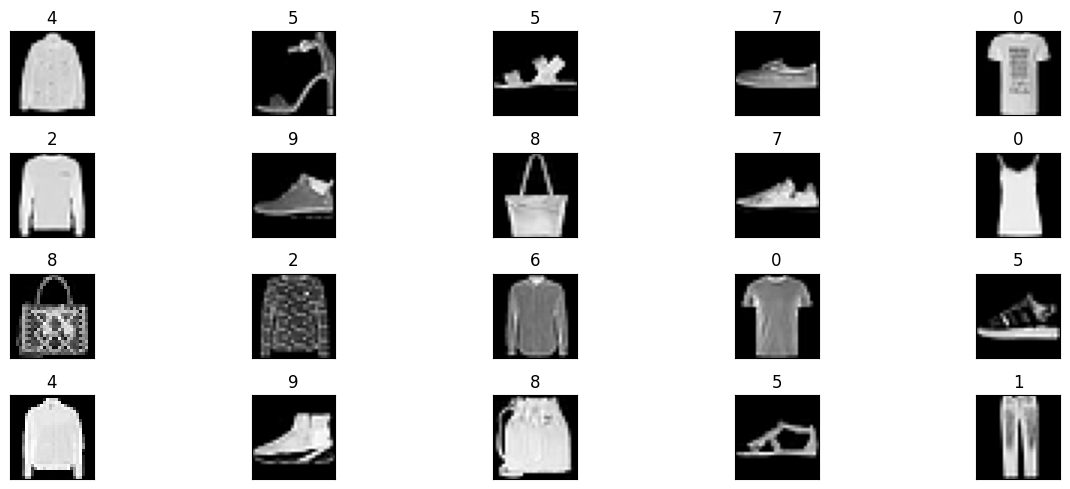

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  # np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()


In [23]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [24]:
model = Classifier()
# defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# using this high value to make sure the update the weight first time
valid_loss_min = np.Inf
epochs = 40
steps = 0
model.train()  # prep model for training
train_losses, valid_losses = [], []
for e in range(epochs):
  running_loss = 0
  valid_loss = 0
  # train the model #
  for images, labels in trainloader:

     optimizer.zero_grad()
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()*images.size(0)

  for images, labels in validloader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
        ))
  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(
          valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.004091 	Validation Loss: 1.552586
validation loss decreased(inf -->1.552586). Saving Model ...
Epoch: 2 	Training Loss: 1.247769 	Validation Loss: 1.057316
validation loss decreased(1.552586 -->1.057316). Saving Model ...
Epoch: 3 	Training Loss: 0.951176 	Validation Loss: 0.877192
validation loss decreased(1.057316 -->0.877192). Saving Model ...
Epoch: 4 	Training Loss: 0.818049 	Validation Loss: 0.783128
validation loss decreased(0.877192 -->0.783128). Saving Model ...
Epoch: 5 	Training Loss: 0.744890 	Validation Loss: 0.733752
validation loss decreased(0.783128 -->0.733752). Saving Model ...
Epoch: 6 	Training Loss: 0.701330 	Validation Loss: 0.697107
validation loss decreased(0.733752 -->0.697107). Saving Model ...
Epoch: 7 	Training Loss: 0.666859 	Validation Loss: 0.668166
validation loss decreased(0.697107 -->0.668166). Saving Model ...
Epoch: 8 	Training Loss: 0.647981 	Validation Loss: 0.641732
validation loss decreased(0.668166 -->0.641732). Saving

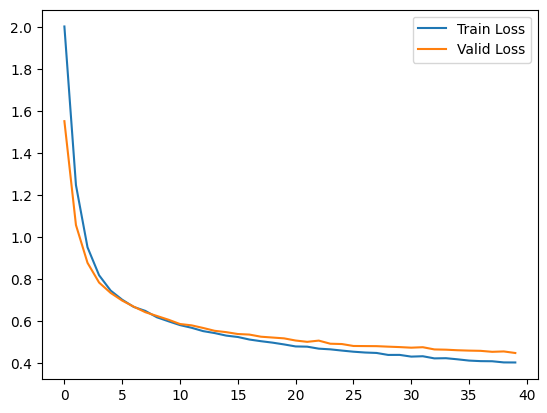

In [25]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()


In [26]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [27]:
# track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
  # forword pass
  output = model(images)
  # calculate the loss
  loss = criterion(output, labels)
  # update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  # calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.439139

Test Accuracy of     0: 82% (827/1000)
Test Accuracy of     1: 95% (950/1000)
Test Accuracy of     2: 73% (736/1000)
Test Accuracy of     3: 88% (880/1000)
Test Accuracy of     4: 81% (810/1000)
Test Accuracy of     5: 89% (897/1000)
Test Accuracy of     6: 50% (500/1000)
Test Accuracy of     7: 90% (909/1000)
Test Accuracy of     8: 94% (949/1000)
Test Accuracy of     9: 95% (950/1000)

Test Accuracy (Overall): 84% (8408/10000)


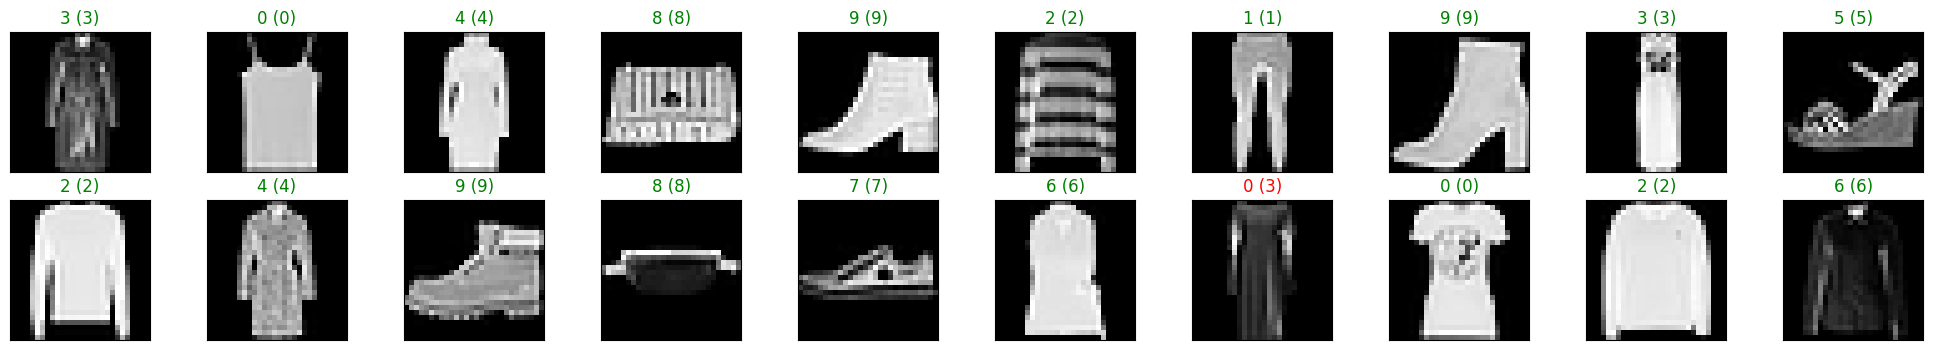

In [30]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))